In [19]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec

import h5py
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from hhs_tools import *

## Old HHS

### 0°

C:\Users\guilh\AppData\Local\Temp\ipykernel_22020\3484576498.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, header=None, skiprows=first_row, skipfooter=last_row)


Test Fit --> [-2.65879642e-03  9.98372316e+00  1.13087350e+01 -5.14686136e-04]
[-1.32115242e-01  6.53141465e+00  1.14533142e+01 -5.04314658e-04]


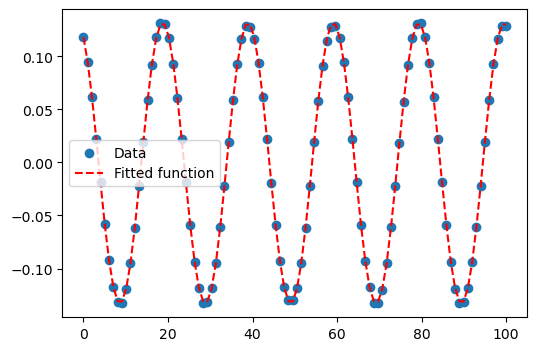

In [20]:
df = readOldHHS("./data/N444/N444_A_2.RAW", degree=0, columns=["turns","voltage","Hz"])
# x_data = df["turns"]
y_data = df["voltage"]
x_data = np.linspace(0, 100, 100)

# Test first fit
params, params_covariance = curve_fit(sin_fit, x_data, y_data, p0=[0.14, 10, 10, 10])
print(f"Test Fit --> {params}")
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, sin_fit(x_data, 0.14,6.55,11,0), "--g",label='Pre-fit')

# Fit the data
params, params_covariance_ref_0 = curve_fit(sin_fit, x_data, y_data, p0=[0.14,6.55,11,0])
print(params)
plt.plot(x_data, sin_fit(x_data, params[0], params[1], params[2], params[3]), "--r",label='Fitted function')
plt.legend(loc='best')
plt.show()

### 90°

In [21]:
df = readOldHHS("./data/N444/N444_A_2.RAW", degree=90, columns=["turns","voltage","Hz"])
# x_data = df["turns"]
y_data = df["voltage"]
x_data = np.linspace(0, 100, 100)

# Test first fit
params, params_covariance = curve_fit(sin_fit, x_data, y_data, p0=[0.14, 10, 10, 10])
print(f"Test Fit --> {params}")
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, sin_fit(x_data, 0.14,6.55,11,0), "--g",label='Pre-fit')

# Fit the data
params, params_covariance_ref_90 = curve_fit(sin_fit, x_data, y_data, p0=[0.14,6.55,11,0])
print(params)
plt.plot(x_data, sin_fit(x_data, params[0], params[1], params[2], params[3]), "--r",label='Fitted function')
plt.legend(loc='best')
plt.show()

Test Fit --> [ 1.53003511e-05  1.01561238e+01  1.87142979e+00 -1.38560931e-06]
[-1.74713303e-03  6.53134160e+00  1.25315178e+01 -1.26827959e-06]


#### Magnetization Tests

In [ ]:
import numpy as np

delta_t1 = aperture / 1000.0
delta_t2 = 1.0 / (pts_per_rev * speed)
factor = delta_t1 / (2.0 * delta_t2)


Delta_phi: 0.12977600044938908
Frequency: 2.065449196621151 Hz
ampc: 0.1198462332855001
amps: 0.056059129590301265
amp: 0.1323092802608521
phi: -0.567299605032878
mz: 0.13230279486542684
my: -0.0013100053211702815
-------------------------
 M_z      =  6.40552162124486E+01
 M_y (0)  = -6.34247176504270E-01
-------------------------
 averaged speed (Hz):  2.06544919662163E+00

 1 amplitude (0) (mV/Hz):  6.40583561567454E+01
 1 phase (0) (rad): -9.90124595308712E-03



c:\Users\guilh\Desktop\dev\hhs-trigger-ui\hhs_tools.py:117: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, header=None, skiprows=first_row, skipfooter=last_row)


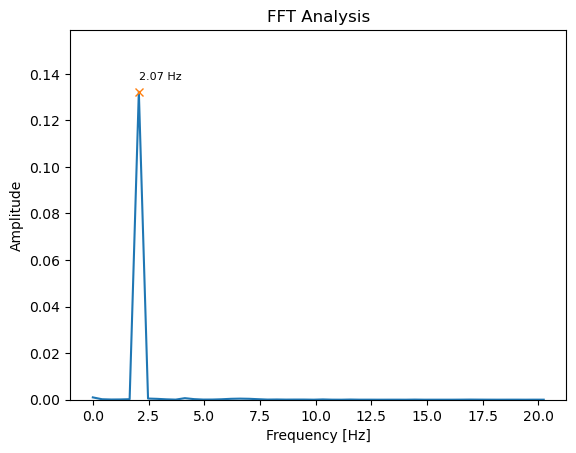

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec

import h5py
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from hhs_tools import *

# Plot FFT
df_raw = readOldHHS("./_old/N444/N444_A_1.RAW", degree=0, columns=["turns","voltage","Hz"])
df_dat = readOldHHS("./_old/N444/N444_A_1.DAT", degree=0, columns=["turns","voltage","residual"])

DVM1Data_Aperture = 0.02 # value for NPLC=1

yrawdata = np.array(df_raw["voltage"])
yresdata = np.array(df_dat["residual"])
N = len(yrawdata)
freq = df["Hz"].mean()
T = (df["turns"][1] - df["turns"][0]) / freq

# speed correction
factor = DVM1Data_Aperture / (2 * freq)

for ii in range(len(yrawdata) - 1):
    yres_local = yresdata[ii] * (1.0 - factor) + yresdata[ii + 1] * factor
    y_data[ii] = yrawdata[ii] / (1.0 + yres_local / speed)
# Handle the last data point
y_data[-1] = yrawdata[-1] / (1.0 + yresdata[-1] / speed)

# Fourier Analysis
fy = fft(y_data)
xf = fftfreq(N, T)[:N//2]

amp0 = 2.0/N * np.abs(fy[0:N//2])

idx = np.argmax(np.abs(fy))
ampc = 2 * np.real(fy[idx]) / N
amps = 2 * np.imag(fy[idx]) / N
phi = math.atan2(-amps, ampc)
amp = ampc / math.cos(phi)

# Phase corrections for 0 degrees
Delta_phi = 0.5 * DVM1Data_Aperture * 2.0 * math.pi * freq
print(f"Delta_phi: {Delta_phi}")
phi -= Delta_phi

if amp < 0.0:
    amp = -amp
    phi += math.pi
if phi > 2.0 * math.pi:
    phi -= 2.0 * math.pi


# Calculate magnetization components for 0 degrees
radgra = 180 / math.pi
mz = amp * math.cos(phi / radgra)
my_0 = amp * math.sin(phi / radgra)

print(f"Frequency: {xf[idx]} Hz")
print(f"ampc: {ampc}")
print(f"amps: {amps}")
print(f"amp: {amp}")
print(f"phi: {phi}")
print(f"mz: {mz}")
print(f"my: {my_0}")


print('-------------------------')
print(f' M_z      = {1000 * mz / abs(freq): .14E}')
print(f' M_y (0)  = {1000 * my_0 / abs(freq): .14E}')
print('-------------------------')
print(f' averaged speed (Hz): {freq: .14E}')
print('')
print(f' 1 amplitude (0) (mV/Hz): {1000*amp/freq: .14E}')
print(f' 1 phase (0) (rad): {phi/radgra: .14E}')
print('')

fig1, ax1 = plt.subplots()
ax1.plot(xf, amp0)
ax1.set_ylim(0, amp0.max() * 1.2)
ax1.set_title("FFT Analysis")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Amplitude")
peaks0, _ = find_peaks(amp0, height= amp0.max()*0.1, threshold=amp0.max()*0.1)
ax1.plot(xf[peaks0], amp0[peaks0], "x")
for i in peaks0:
    ax1.text(xf[i], amp0[i]*1.04, f"{xf[i]:.2f} Hz", fontsize=8)  

## New HHS

### 0°

In [4]:
#  read the hdf5 file
path = "./data/2024-07-17_16-00-07_measurement_0deg.hdf5"
f = h5py.File(path, 'r')

#  create dictionary with attributs
res_attrs = list(f["Measurement"].attrs.keys())
attrs_values = list(f["Measurement"].attrs.values())
data = {'Attribute': res_attrs, 'Value': attrs_values}

# round the value in the data with attribute = "Home Position"
home_position_index = data["Attribute"].index("Home Position")
data["Value"][home_position_index] = round(data["Value"][home_position_index], 2)

# prepare attributes for table
df = pd.DataFrame(data)
attrs_values_str = [str(value) for value in attrs_values]  # Convert numpy.float64 values to string

# read result of measurements
dset = f["Measurement"]["Results"]

# plot
fig = plt.figure(figsize=(12, 8))

gs = gridspec.GridSpec(3, 1)  # Divide the figure into 3 rows and 1 column

ax0 = plt.subplot(gs[0:2])  # Assign the first 2 rows to the first plot
ax0.plot(dset["position"], dset["voltage"])
ax0.set_ylabel("Voltage (V)")
ax0.set_xlabel("Position (ct)")
ax0.set_title("Voltage vs Position")

ax1 = plt.subplot(gs[2])  # Assign the third row to the second plot
table = ax1.table(cellText=[attrs_values_str], colLabels=res_attrs,loc="top")  # Pass the converted values to plt.table()
ax1.axis("off")  # Hide the axes
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Adjust the table size

plt.subplots_adjust(hspace = 1)  # Adjusts the vertical space

plt.show()

Frequency:  65536.0


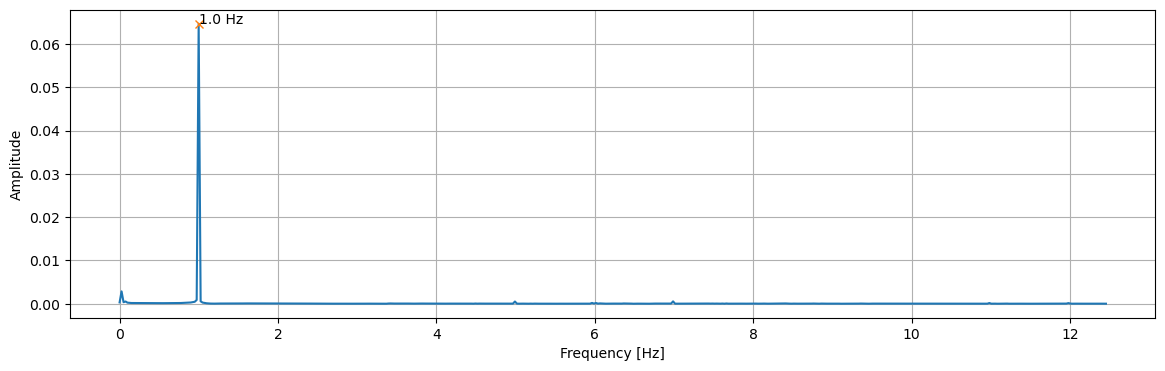

In [24]:
resolution = 65536
freq = data["Value"][data["Attribute"].index("Jog Velocity")] * resolution / 360

print("Frequency: ", freq)

y = dset["voltage"]
N = y.size
T = (dset["position"][1] - dset["position"][0])/freq  # sample spacing
fy = fft(y)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(14, 4))
plt.plot(xf, 2.0/N * np.abs(fy[0:N//2]))
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")

# mark peaks
peaks, _ = find_peaks(2.0/N * np.abs(fy[0:N//2]), height=0.01)
plt.plot(xf[peaks], 2.0/N * np.abs(fy[0:N//2])[peaks], "x")
for i in peaks:
    plt.text(xf[i], 2.0/N * np.abs(fy[0:N//2])[i], str(round(xf[i], 2))+" Hz")


plt.grid()
plt.show()

[-2.12190926e-04  1.00017160e+01  8.29282921e+00  9.10202058e-05]
[6.49619219e-02 2.50755790e-01 1.03560046e+01 7.78756590e-05]


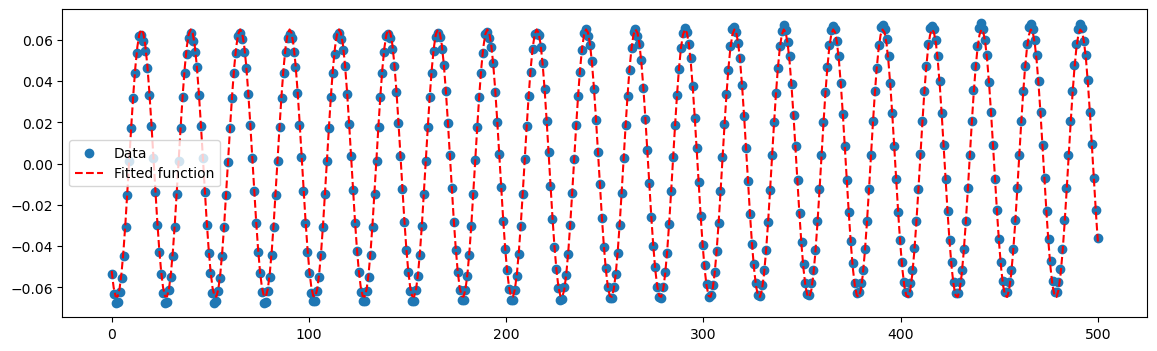

In [25]:
y_data = dset["voltage"][250:750]
x_data = np.linspace(0, 500, 500)

# Test first fit
params, params_covariance = curve_fit(sin_fit, x_data, y_data, p0=[0.14, 10, 10, 10])
print(params)
plt.figure(figsize=(14, 4))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, sin_fit(x_data, 0.14,0.25,10.3,0), "--g",label='Pre-fit')

# Fit the data
params, params_covariance_new_0 = curve_fit(sin_fit, x_data, y_data, p0=[0.14,0.25,10.3,0])
print(params)
plt.plot(x_data, sin_fit(x_data, params[0], params[1], params[2], params[3]), "--r",label='Fitted function')
plt.legend(loc='best')
plt.show()

### 90°

In [3]:
#  read the hdf5 file
path = "./data/20240802_155208_N444_90deg_results.hdf5"
f = h5py.File(path, 'r')

#  create dictionary with attributs
res_attrs = list(f["Measurement"].attrs.keys())
attrs_values = list(f["Measurement"].attrs.values())
data = {'Attribute': res_attrs, 'Value': attrs_values}

# round the value in the data with attribute = "Home Position"
home_position_index = data["Attribute"].index("Home Position")
data["Value"][home_position_index] = round(data["Value"][home_position_index], 2)

# prepare attributes for table
df = pd.DataFrame(data)
attrs_values_str = [str(value) for value in attrs_values]  # Convert numpy.float64 values to string

# read result of measurements
dset = f["Measurement"]["Results"]

# plot
fig = plt.figure(figsize=(12, 8))

gs = gridspec.GridSpec(3, 1)  # Divide the figure into 3 rows and 1 column

ax0 = plt.subplot(gs[0:2])  # Assign the first 2 rows to the first plot
ax0.plot(dset["position"], dset["voltage"])
ax0.set_ylabel("Voltage (V)")
ax0.set_xlabel("Position (ct)")
ax0.set_title("Voltage vs Position")

ax1 = plt.subplot(gs[2])  # Assign the third row to the second plot
table = ax1.table(cellText=[attrs_values_str], colLabels=res_attrs,loc="top")  # Pass the converted values to plt.table()
ax1.axis("off")  # Hide the axes
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Adjust the table size

plt.subplots_adjust(hspace = 1)  # Adjusts the vertical space

plt.show()

In [4]:
resolution = 65536
freq = data["Value"][data["Attribute"].index("Jog Velocity")] * resolution / 360

print("Frequency: ", freq)

y = dset["voltage"]
N = y.size
T = (dset["position"][1] - dset["position"][0])/freq  # sample spacing
fy = fft(y)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(14, 4))
plt.plot(xf, 2.0/N * np.abs(fy[0:N//2]))
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")

# mark peaks
peaks, _ = find_peaks(2.0/N * np.abs(fy[0:N//2]), height=0.001)
plt.plot(xf[peaks], 2.0/N * np.abs(fy[0:N//2])[peaks], "x")
for i in peaks:
    plt.text(xf[i], 2.0/N * np.abs(fy[0:N//2])[i], str(round(xf[i], 2))+" Hz")

plt.grid()
plt.show()

Frequency:  131072.0


## Comparison

In [29]:
std_dev_ref = np.sqrt(np.diag(params_covariance_ref_0))
std_dev_new = np.sqrt(np.diag(params_covariance_new_0))

print(f"Standard Deviation - Old HHS --> {std_dev_ref}")
print(f"Standard Deviation - New HHS --> {std_dev_new}")

Standard Deviation - Old HHS --> [1.32613252e-04 3.49308789e-05 1.98584762e-03 9.47474146e-05]
Standard Deviation - New HHS --> [1.25754568e-04 1.33913767e-05 3.89061627e-03 8.89563154e-05]


## Zero Position

In [ ]:
# Calculate zero degree pointer
# 0-->1 has one turn
# 1-->2 has half turn
# 2-->3 has half turn
# 3-->4 has 3/2 turn
motor_pos_zero_degree_raw = [192203450, 192269000, 192301768, 192334548]
motor_pos_zero_degree_new = [0,0,0,0]
motor_pos_zero_degree_new[0] = motor_pos_zero_degree_raw[0]
motor_pos_zero_degree_new[1] = motor_pos_zero_degree_raw[1]-65535
motor_pos_zero_degree_new[2] = motor_pos_zero_degree_raw[2]-1.5*65535
motor_pos_zero_degree_new[3] = motor_pos_zero_degree_raw[3]-2*65535

motor_pos_zero_degree_new_avg = np.average(motor_pos_zero_degree_new)
motor_pos_zero_degree_new_std = np.std(motor_pos_zero_degree_new)

print(f"Average of a 0° candidate -- > {motor_pos_zero_degree_new_avg}")
print(f"Standard Deviation [counts] -- > {motor_pos_zero_degree_new_std}")
print(f"Standard Deviation [°]  -- > {motor_pos_zero_degree_new_std * 360 / 65535}")

Average of a 0° candidate -- > 192203464.625
Standard Deviation [counts] -- > 9.920779959257235
Standard Deviation [°]  -- > 0.05449730350702075


## Translation Old Pascal Code

In [1]:
import numpy as np
import math
import h5py
import pandas as pd

def positions_to_degrees(positions, reference_position):
    counts_per_revolution = 65535
    degrees_per_revolution = 360
    counts_per_degree = counts_per_revolution / degrees_per_revolution
    differences_in_counts = positions - reference_position
    angle_differences = differences_in_counts / counts_per_degree
    number_of_turns = (np.max(positions) - np.min(positions)) / (360 * counts_per_degree)
    normalized_angles = np.mod(angle_differences, 360)
    normalized_angles = (normalized_angles + 360) % 360
    return normalized_angles, number_of_turns

def read_data(file_path):
    with h5py.File(file_path, 'r') as f:
        res_attrs = list(f["Measurement"].attrs.keys())
        attrs_values = list(f["Measurement"].attrs.values())
        data = dict(zip(res_attrs, attrs_values))
        data["Home Position"] = round(data["Home Position"], 2)

        dset = f["Measurement"]["Results"]
        voltage = dset["voltage"][:]
        position = dset["position"][:]
        degrees, n_turns = positions_to_degrees(position, 192203464.625)
        df = pd.DataFrame({"Position": position, "Voltage": voltage, "Degrees": degrees})

    return data, df, voltage, degrees, n_turns

def fourier_analysis(ydata, iord, xiperiod, xnperiod, xsign):
    ampc = np.zeros(iord + 1)
    amps = np.zeros(iord + 1)
    amp = np.zeros(iord + 1)
    phi = np.zeros(iord + 1)
    
    for i in range(1, iord + 1):
        xi = i
        xk = (2.0 * math.pi * xi) / xiperiod
        
        for j in range(len(ydata)):
            ampc[i] += math.cos(xsign * xk * j) * ydata[j]
            amps[i] += math.sin(xsign * xk * j) * ydata[j]
        
        ampc[i] = (2.0 * ampc[i]) / (xnperiod * xiperiod)
        amps[i] = (2.0 * amps[i]) / (xnperiod * xiperiod)
        
        phi[i] = math.atan2(-amps[i], ampc[i]) # angle in radians
        amp[i] = ampc[i] / math.cos(phi[i]) # amp in volts
    
    return amp, phi

def adjust_amplitude_phase(amp, phi, iord):
    for i in range(1, iord + 1):
        if amp[i] < 0.0:
            amp[i] = -amp[i]
            phi[i] += math.pi
        if phi[i] > 2.0 * math.pi:
            phi[i] -= 2.0 * math.pi
    return amp, phi

# Read and process data for 0 degrees
data_0, df_0, ydata0, degrees_0, n_turns_0 = read_data("./data/2024-07-17_16-00-07_measurement_0deg.hdf5")

# Read and process data for 90 degrees
data_90, df_90, ydata90, degrees_90, n_turns_90 = read_data("./data/20240802_154708_N444_90deg_results.hdf5")

# Extract necessary data
speed0 = data_0["Jog Velocity"] / 360  # in Hz
speed90 = data_90["Jog Velocity"] / 360  # in Hz
DVM1Data_Aperture = 2.0e1  # value from the .log old files
dacdata_endvoltage = 8.0e-1  # value from the .log old files
iord = 1  # value from the .log old files

# Constants
xsign = -1.0 if dacdata_endvoltage < 0 else 1.0  # sign of the DAC data ??
radgra = 180 / np.pi  # conversion from degrees to radians

# Fourier analysis for zero degrees data
xnperiod_0 = int(np.round(n_turns_0, 0))  # number of revolutions
xiperiod_0 = len(ydata0) / xnperiod_0  # number of points per revolution

amp0, phi0 = fourier_analysis(ydata0, iord, xiperiod_0, xnperiod_0, xsign)

# Fourier analysis for ninety degrees data
xnperiod_90 = int(np.round(n_turns_90, 0))  # number of revolutions
xiperiod_90 = len(ydata90) / xnperiod_90  # number of points per revolution

amp90, phi90 = fourier_analysis(ydata90, iord, xiperiod_90, xnperiod_90, xsign)

# Phase corrections for 0 degrees
Delta_phi0 = 0.5 * (DVM1Data_Aperture / 1000.0) * speed0 * 2.0 * math.pi
for i in range(1, iord + 1):
    phi0[i] -= i * Delta_phi0

# Ensure amplitudes are positive and adjust phases
amp0, phi0 = adjust_amplitude_phase(amp0, phi0, iord)

# Phase corrections for 90 degrees
Delta_phi90 = 0.5 * (DVM1Data_Aperture / 1000.0) * speed90 * 2.0 * math.pi
for i in range(1, iord + 1):
    phi90[i] -= i * Delta_phi90

# Ensure amplitudes are positive and adjust phases
amp90, phi90 = adjust_amplitude_phase(amp90, phi90, iord)

# Calculate magnetization components for 0 degrees
mz = amp0[1] * math.cos(phi0[1] / radgra)
my_0 = amp0[1] * math.sin(phi0[1] / radgra)

# Calculate magnetization components for 90 degrees
mx = -amp90[1] * math.cos(phi90[1] / radgra)
my_90 = amp90[1] * math.sin(phi90[1] / radgra)

# Normalized RMS values
normalized_data_rms_0 = np.sqrt(np.mean(np.square(ydata0))) * 1000.0 / (abs(speed0) * len(ydata0))
normalized_data_rms_90 = np.sqrt(np.mean(np.square(ydata90))) * 1000.0 / (abs(speed90) * len(ydata90))

# Print results
print('-------------------------')
print(f' M_z      = {1000 * mz / abs(speed0): .14E}')
print(f' M_y (0)  = {1000 * my_0 / abs(speed0): .14E}')
print(f' M_y (90) = {1000 * my_90 / abs(speed90): .14E}')
print(f' M_x      = {1000 * mx / abs(speed90): .14E}')
print('-------------------------')
print('')
print('-------------------------')
print(' zero degree position')
print('-------------------------')
print(f' averaged speed (Hz): {speed0: .14E}')
print(f' normalized data_rms (0 degree) (0/00): {normalized_data_rms_0: .14E}')
# print(f' normalized speed_rms (0 degree) (0/00): {normalized_speed_rms_0: .14E}')
print('')
print(f' order of Fourier analysis: {iord}')
print(f' 1 amplitude (0) (mV/Hz): {1000*amp0[1]/speed0: .14E}')
print(f' 1 phase (0) (rad): {phi0[1]/radgra: .14E}')
print('')
print('-------------------------')
print(' ninety degree position')
print('-------------------------')
print(f' averaged speed 0° (Hz): {speed0: .14E}')
print(f' normalized data_rms (90 degree) (0/00): {normalized_data_rms_90: .14E}')
# print(f' normalized speed_rms (90 degree) (0/00): {normalized_speed_rms_90: .14E}')
print('')
print(f' order of Fourier analysis: {iord}')
print(f' 1 amplitude (90) (mV/Hz): {1000 * amp90[1]/speed90: .14E}')
print(f' 1 phase (90) (rad): {phi90[1]/radgra: .14E}')




-------------------------
 M_z      =  6.46559351693195E+01
 M_y (0)  =  2.28066420070351E+00
 M_y (90) = -2.06577442118821E-02
 M_x      = -1.15476598219580E+00
-------------------------

-------------------------
 zero degree position
-------------------------
 averaged speed (Hz):  2.00000000000000E+00
 normalized data_rms (0 degree) (0/00):  4.57713888559474E-02

 order of Fourier analysis: 1
 1 amplitude (0) (mV/Hz):  6.46961465762500E+01
 1 phase (0) (rad):  3.52592379741869E-02

-------------------------
 ninety degree position
-------------------------
 averaged speed 0° (Hz):  2.00000000000000E+00
 normalized data_rms (90 degree) (0/00):  1.16891196357312E-03

 order of Fourier analysis: 1
 1 amplitude (90) (mV/Hz):  1.15495074182086E+00
 1 phase (90) (rad): -1.78872094600606E-02


### Comparison with Scipy

In [16]:
import numpy as np
import math
import h5py
import pandas as pd
from scipy.fft import fft, fftfreq

def positions_to_degrees(positions, reference_position):
    counts_per_revolution = 65535
    degrees_per_revolution = 360
    counts_per_degree = counts_per_revolution / degrees_per_revolution
    differences_in_counts = positions - reference_position
    angle_differences = differences_in_counts / counts_per_degree
    number_of_turns = (np.max(positions) - np.min(positions)) / (360 * counts_per_degree)
    normalized_angles = np.mod(angle_differences, 360)
    normalized_angles = (normalized_angles + 360) % 360
    return normalized_angles, number_of_turns

def read_data(file_path):
    with h5py.File(file_path, 'r') as f:
        res_attrs = list(f["Measurement"].attrs.keys())
        attrs_values = list(f["Measurement"].attrs.values())
        data = dict(zip(res_attrs, attrs_values))
        data["Home Position"] = round(data["Home Position"], 2)

        dset = f["Measurement"]["Results"]
        voltage = dset["voltage"][:]
        position = dset["position"][:]
        degrees, n_turns = positions_to_degrees(position, 192203464.625)
        df = pd.DataFrame({"Position": position, "Voltage": voltage, "Degrees": degrees})

    return data, df, voltage, degrees, n_turns

def custom_fourier_analysis(ydata, iord, xiperiod, xnperiod, xsign):
    ampc = np.zeros(iord + 1)
    amps = np.zeros(iord + 1)
    amp = np.zeros(iord + 1)
    phi = np.zeros(iord + 1)

    for i in range(1, iord + 1):
        xi = i
        xk = (2.0 * math.pi * xi) / xiperiod
        for j in range(len(ydata)):
            ampc[i] += math.cos(xsign * xk * j) * ydata[j]
            amps[i] += math.sin(xsign * xk * j) * ydata[j]

        ampc[i] = (2.0 * ampc[i]) / (xnperiod * xiperiod)
        amps[i] = (2.0 * amps[i]) / (xnperiod * xiperiod)

        phi[i] = math.atan2(-amps[i], ampc[i])
        amp[i] = ampc[i] / math.cos(phi[i])

    
    return amp, phi

def scipy_fourier_analysis(ydata, iord, xiperiod, xnperiod, xsign):
    # Perform FFT
    n = len(ydata)
    yf = fft(ydata)
    xf = fftfreq(n, 1 / xiperiod)[:n//2]

    # Extract the amplitude and phase
    ampc = np.zeros(iord + 1)
    amps = np.zeros(iord + 1)
    amp = np.zeros(iord + 1)
    phi = np.zeros(iord + 1)

    for i in range(1, iord + 1):
        idx = np.argmin(np.abs(xf - i))
        print(f"idx: {idx}")
        ampc[i] = 2.0 * np.real(yf[idx]) / n
        amps[i] = 2.0 * np.imag(yf[idx]) / n
        print(f"ampc[{i}]: {ampc[i]}")
        print(f"amps[{i}]: {amps[i]}")

        phi[i] = math.atan2(-amps[i], ampc[i])
        amp[i] = ampc[i] / math.cos(phi[i])
        print(f"amp[{i}]: {amp[i]}")
        print(f"phi[{i}]: {phi[i]}")

    return amp, phi

def adjust_amplitude_phase(amp, phi, iord):
    for i in range(1, iord + 1):
        if amp[i] < 0.0:
            amp[i] = -amp[i]
            phi[i] += math.pi
        if phi[i] > 2.0 * math.pi:
            phi[i] -= 2.0 * math.pi
    return amp, phi

# Read and process data for 0 degrees
data_0, df_0, ydata0, degrees_0, n_turns_0 = read_data("./data/2024-07-17_16-00-07_measurement_0deg.hdf5")

# Read and process data for 90 degrees
data_90, df_90, ydata90, degrees_90, n_turns_90 = read_data("./data/2024-07-17_16-11-07_measurement_90deg.hdf5")

# Extract necessary data
speed0 = data_0["Jog Velocity"] / 360  # in Hz
speed90 = data_90["Jog Velocity"] / 360  # in Hz
DVM1Data_Aperture = 2.0e1  # value from the .log old files
dacdata_endvoltage = 8.0e-1  # value from the .log old files
iord = 1  # value from the .log old files

# Constants
xnperiod = int(np.round(np.mean([n_turns_0, n_turns_90]), 0))  # number of revolutions
xiperiod = len(ydata0) / xnperiod  # number of points per revolution
xsign = -1.0 if dacdata_endvoltage < 0 else 1.0  # sign of the DAC data ??
radgra = 180 / np.pi  # conversion from degrees to radians

# Fourier analysis for zero and ninety degrees data
amp0_custom, phi0_custom = custom_fourier_analysis(ydata0, iord, xiperiod, xnperiod, xsign)
amp90_custom, phi90_custom = custom_fourier_analysis(ydata90, iord, xiperiod, xnperiod, xsign)

print(amp0_custom)
print(phi0_custom)

amp0_scipy, phi0_scipy = scipy_fourier_analysis(ydata0, iord, xiperiod, xnperiod, xsign)
amp90_scipy, phi90_scipy = scipy_fourier_analysis(ydata90, iord, xiperiod, xnperiod, xsign)

# Phase corrections
Delta_phi0 = 0.5 * (DVM1Data_Aperture / 1000.0) * speed0 * 2.0 * math.pi
Delta_phi90 = 0.5 * (DVM1Data_Aperture / 1000.0) * speed90 * 2.0 * math.pi

for i in range(1, iord + 1):
    phi0_custom[i] -= i * Delta_phi0
    phi90_custom[i] -= i * Delta_phi90

    phi0_scipy[i] -= i * Delta_phi0
    phi90_scipy[i] -= i * Delta_phi90

# Ensure amplitudes are positive and adjust phases
amp0_custom, phi0_custom = adjust_amplitude_phase(amp0_custom, phi0_custom, iord)
amp90_custom, phi90_custom = adjust_amplitude_phase(amp90_custom, phi90_custom, iord)

amp0_scipy, phi0_scipy = adjust_amplitude_phase(amp0_scipy, phi0_scipy, iord)
amp90_scipy, phi90_scipy = adjust_amplitude_phase(amp90_scipy, phi90_scipy, iord)

# Calculate magnetization components for custom Fourier
mz_custom = amp0_custom[1] * math.cos(phi0_custom[1] / radgra)
my_0_custom = amp0_custom[1] * math.sin(phi0_custom[1] / radgra)
mx_custom = -amp90_custom[1] * math.cos(phi90_custom[1] / radgra)
my_90_custom = amp90_custom[1] * math.sin(phi90_custom[1] / radgra)

# Calculate magnetization components for scipy Fourier
mz_scipy = amp0_scipy[1] * math.cos(phi0_scipy[1] / radgra)
my_0_scipy = amp0_scipy[1] * math.sin(phi0_scipy[1] / radgra)
mx_scipy = -amp90_scipy[1] * math.cos(phi90_scipy[1] / radgra)
my_90_scipy = amp90_scipy[1] * math.sin(phi90_scipy[1] / radgra)

# Print results for custom Fourier
print('-------------------------')
print('Custom Fourier Analysis Results:')
print('-------------------------')
print(f' M_z      = {1000 * mz_custom / abs(speed0): .14E}')
print(f' M_y (0)  = {1000 * my_0_custom / abs(speed0): .14E}')
print(f' M_y (90) = {1000 * my_90_custom / abs(speed90): .14E}')
print(f' M_x      = {1000 * mx_custom / abs(speed90): .14E}')
print('')

# Print results for scipy Fourier
print('-------------------------')
print('Scipy Fourier Analysis Results:')
print('-------------------------')
print(f' M_z      = {1000 * mz_scipy / abs(speed0): .14E}')
print(f' M_y (0)  = {1000 * my_0_scipy / abs(speed0): .14E}')
print(f' M_y (90) = {1000 * my_90_scipy / abs(speed90): .14E}')
print(f' M_x      = {1000 * mx_scipy / abs(speed90): .14E}')


[0.         0.12939229]
[0.         2.14586923]
idx: 40
ampc[1]: -0.07037594677039821
amps[1]: 0.10857988599843234
amp[1]: 0.12939229315249998
phi[1]: -2.145869230911913
idx: 40
ampc[1]: 0.0011140621824020833
amps[1]: 0.0007152666416181081
amp[1]: 0.001323911218651062
phi[1]: -0.5707553567442146
-------------------------
Custom Fourier Analysis Results:
-------------------------
 M_z      =  6.46559351693195E+01
 M_y (0)  =  2.28066420070351E+00
 M_y (90) =  1.17362364712350E-02
 M_x      = -1.32385919780905E+00

-------------------------
Scipy Fourier Analysis Results:
-------------------------
 M_z      =  6.46453090575770E+01
 M_y (0)  = -2.56425401744302E+00
 M_y (90) = -1.46397540414351E-02
 M_x      = -1.32383027328723E+00
